In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F

random_seed = 213
torch.manual_seed(random_seed)

In [3]:
data_dir  = '/kaggle/input/indoor-scenes-cvpr-2019/indoorCVPR_09/Images'

classes = os.listdir(data_dir)
print(classes)
print(f"length: {len(classes)}")

['meeting_room', 'grocerystore', 'trainstation', 'mall', 'bar', 'auditorium', 'laboratorywet', 'florist', 'closet', 'livingroom', 'pantry', 'airport_inside', 'prisoncell', 'locker_room', 'elevator', 'dentaloffice', 'laundromat', 'fastfood_restaurant', 'casino', 'dining_room', 'kindergarden', 'concert_hall', 'waitingroom', 'bathroom', 'corridor', 'bedroom', 'hairsalon', 'kitchen', 'tv_studio', 'artstudio', 'library', 'inside_bus', 'restaurant_kitchen', 'inside_subway', 'buffet', 'bookstore', 'museum', 'lobby', 'gameroom', 'shoeshop', 'garage', 'poolinside', 'clothingstore', 'deli', 'subway', 'jewelleryshop', 'stairscase', 'toystore', 'classroom', 'restaurant', 'nursery', 'bakery', 'bowling', 'office', 'operating_room', 'warehouse', 'studiomusic', 'church_inside', 'computerroom', 'cloister', 'greenhouse', 'winecellar', 'gym', 'videostore', 'hospitalroom', 'children_room', 'movietheater']
length: 67


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

dataset = ImageFolder(data_dir, transform = transformations)
print(f"dataset size: {len(dataset)}")

dataset size: 15620


Label:airport_inside (Class No: 0)


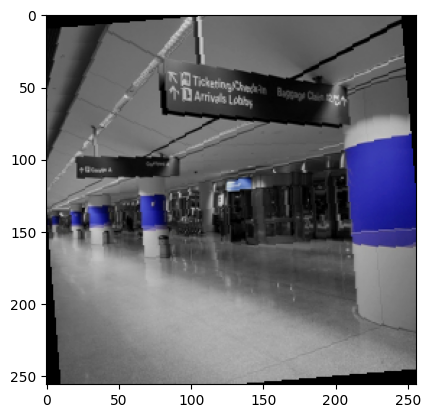

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print(f"Label:{dataset.classes[label]} (Class No: {label})")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[165]
show_sample(img, label)

In [21]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64
train_ds, val_ds, test_ds = random_split(dataset, [13000, 2000, 620])
# print(f"train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

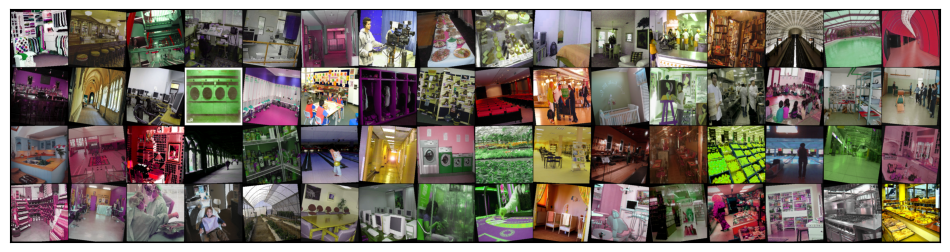

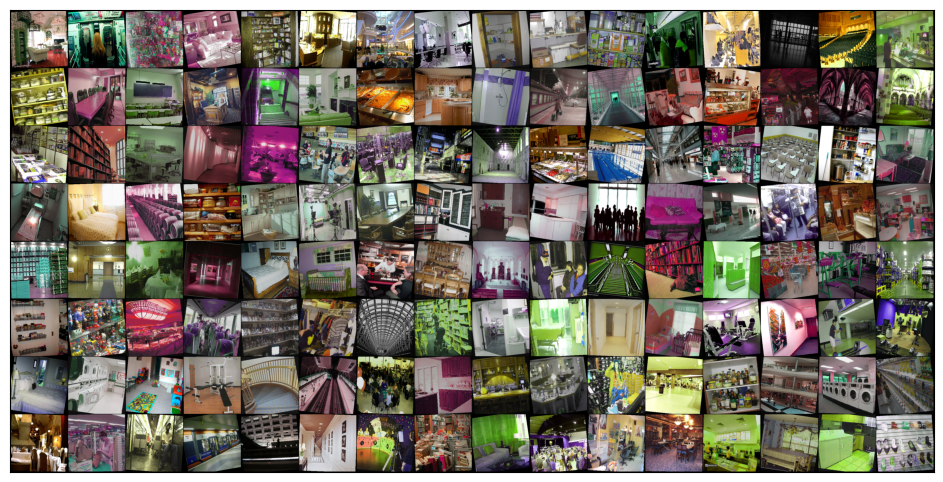

In [22]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

show_batch(train_loader)
show_batch(val_loader)

**Model**

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.sum(preds == labels).item() / len(preds)
    return acc

class ConvClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.mobilenet_v2(pretrained=True)
        self.network.classifier = nn.Linear(self.network.last_channel, len(dataset.classes)) 
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # cross entropy softmax， 
        return loss
    
    @torch.no_grad()
    def valid_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.item(), 'val_acc': acc}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvClassifier().to(device)
optim = torch.optim.Adam(model.parameters(), 6e-5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 219MB/s]


**Training**

In [24]:
history = []

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
num_epochs = 20

for epoch in range(num_epochs):  # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
        loss = model.training_step(batch)
        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

    # Validation phase
    model.eval()
    outputs = [model.valid_step(batch) for batch in val_loader]
    result = {
        'val_loss': np.mean([out['val_loss'] for out in outputs]), 
        'val_acc': np.mean([out['val_acc'] for out in outputs]), 
        'train_loss': np.mean(train_losses)
    }
    print(f"[Epoch {epoch+1}] train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    history.append(result)

[Epoch 1] train_loss: 0.8919, val_loss: 0.9808, val_acc: 0.7287
[Epoch 2] train_loss: 0.7569, val_loss: 0.9270, val_acc: 0.7351
[Epoch 3] train_loss: 0.6498, val_loss: 0.8687, val_acc: 0.7562
[Epoch 4] train_loss: 0.5636, val_loss: 0.8477, val_acc: 0.7549
[Epoch 5] train_loss: 0.4928, val_loss: 0.8172, val_acc: 0.7653
[Epoch 6] train_loss: 0.4272, val_loss: 0.8059, val_acc: 0.7626
[Epoch 7] train_loss: 0.3667, val_loss: 0.8021, val_acc: 0.7670
[Epoch 8] train_loss: 0.3236, val_loss: 0.8122, val_acc: 0.7677
[Epoch 9] train_loss: 0.2835, val_loss: 0.8123, val_acc: 0.7686
[Epoch 10] train_loss: 0.2405, val_loss: 0.7662, val_acc: 0.7771
[Epoch 11] train_loss: 0.2117, val_loss: 0.8145, val_acc: 0.7623
[Epoch 12] train_loss: 0.1870, val_loss: 0.8308, val_acc: 0.7654
[Epoch 13] train_loss: 0.1628, val_loss: 0.8120, val_acc: 0.7731
[Epoch 14] train_loss: 0.1420, val_loss: 0.8312, val_acc: 0.7704
[Epoch 15] train_loss: 0.1203, val_loss: 0.8563, val_acc: 0.7611
[Epoch 16] train_loss: 0.1028, val

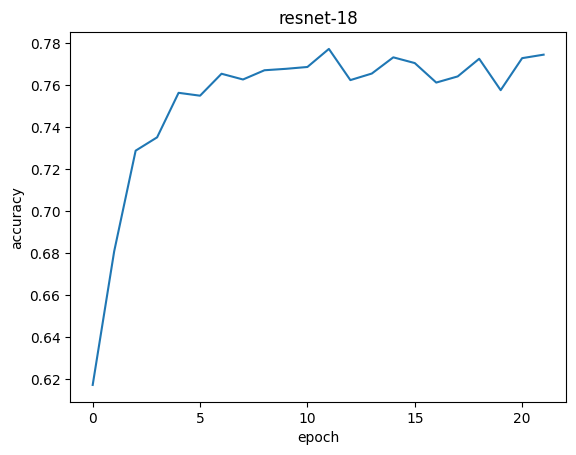

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('resnet-18');

plot_accuracies(history)

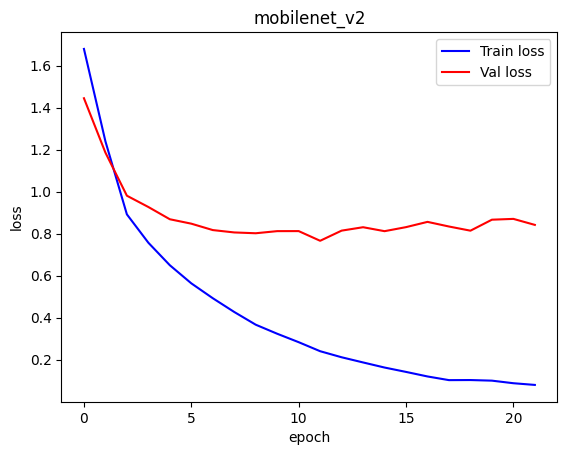

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train loss', 'Val loss'])
    plt.title('mobilenet_v2');

plot_losses(history)

In [34]:
torch.save(model.state_dict(), "mobilenet_v2.pth")

In [38]:
import 
model.loac_state_dict()

SyntaxError: invalid syntax (1162817179.py, line 1)

**Visualizing**

In [41]:
def predict_image(img):
    xb = img.unsqueeze(0).to(device)         # Convert to a batch of 1
    yb = model(xb)                           # Get predictions from model
    prob, preds  = torch.max(yb, dim=1)      # Pick index with highest probability
    return dataset.classes[preds[0].item()]  # Retrieve the class label

Label: deli , Predicted: bakery


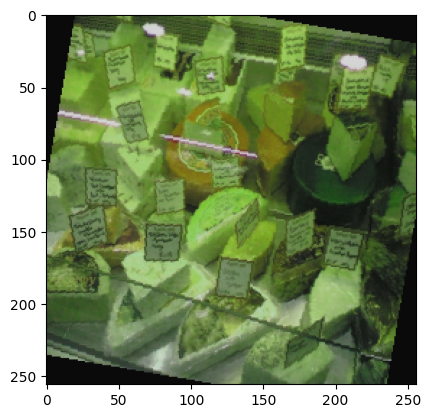

In [42]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img))

Label: bakery , Predicted: bakery


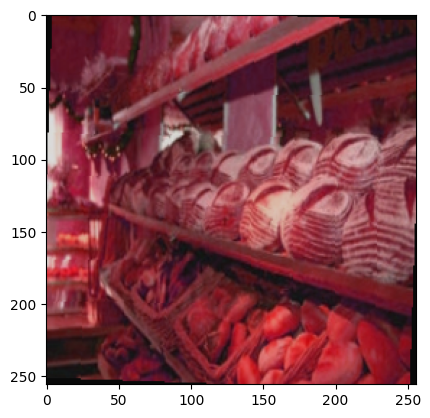

In [44]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img))

Label: casino , Predicted: casino


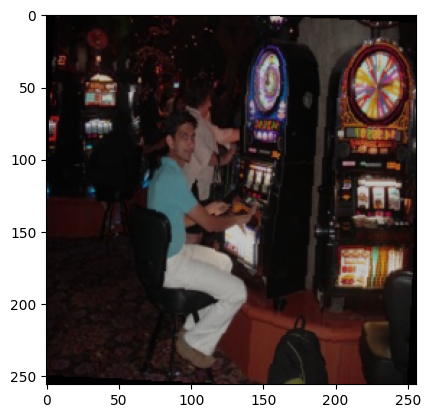

In [46]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img))

**Validation**

In [48]:
import urllib.request
urllib.request.urlretrieve("http://images.squarespace-cdn.com/content/v1/5a7497e29f8dcee376b70f7e/1591630503059-FBBWAYXPWYOK9BTIBMZY/ke17ZwdGBToddI8pDm48kA_SSaoz4elkj-HsZd8gX3Z7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1UWPwZyNcweDIvdeL5kotwkIXjs9g0WibSO_cU-Ijy4Pwg6poS-6WGGnXqDacZer4yQ/74586587_10157705983079085_1307946016988725248_o+%281%29.jpg?format=2500w", "bar.jpg")
urllib.request.urlretrieve("http://www.bocadolobo.com/en/inspiration-and-ideas/wp-content/uploads/2018/03/Discover-the-Ultimate-Master-Bedroom-Styles-and-Inspirations-6_1.jpg", "bedroom.jpg")    
urllib.request.urlretrieve("http://sika.scene7.com/is/image/sika/glo-elevator-appliances?wid=1280&crop=0%2C80%2C4615%2C3212", "elevator.jpg") 
urllib.request.urlretrieve("http://i.pinimg.com/originals/2b/15/9d/2b159da035e4e3aaa30c03ec8ba7816c.jpg", "gameroom.jpg")
urllib.request.urlretrieve("http://i.pinimg.com/originals/a6/d9/d7/a6d9d743da7017a7bcf4a53e46d22f81.jpg", "inside_bus.jpg")
urllib.request.urlretrieve("http://s.wsj.net/public/resources/images/ON-CE927_moviet_B1280_20170714200426.jpg", "theatre.jpg")

HTTPError: HTTP Error 404: Not Found

In [49]:
loaded_model = model

In [52]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image) + ".")

The image resembles bar.


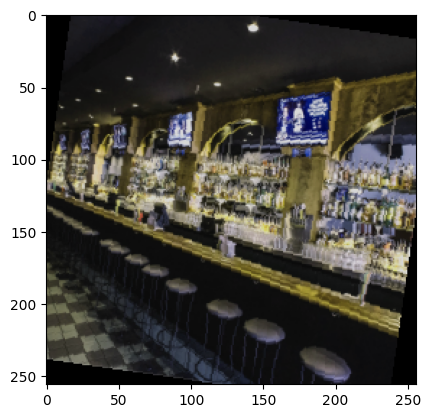

In [53]:
predict_external_image('bar.jpg')